# Feature Interpretation using Generative Adversarial Networks (FIGAN) Tutorial

This tutorial is designed to provide users with the code and understanding of the methods proposed in Hasenstab et al. [ref]. The proposed FIGAN framework comprises the following three steps, assuming a source CNN has already been trained:
1.   Feature Extraction
2.   Generative Model Training
3.   Synthetic Image Analysis

Note the following tutorial is best completed on a GPU for fast computation.



## Creating a source CNN



FIGAN is designed to generate synthetic images that visualize the meaning of features from an independently developed CNN. Therefore, we need a source CNN to interpret!

We use the MNIST keras tutorial found [here](https://keras.io/examples/vision/mnist_convnet/) to create our source CNN.

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import cv2
import os

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


For illustration, we train a source CNN designed to perform the simple task of classifying between the digits "0" and "1"

In [ ]:
# select one-hot encoded digits "0" and "1"
y_train = y_train[:,0:2]
y_test = y_test[:,0:2]
x_train = x_train[np.where(np.sum(y_train, axis = 1) == 1)]
y_train = y_train[np.where(np.sum(y_train, axis = 1) == 1)]
x_test = x_test[np.where(np.sum(y_test, axis = 1) == 1)]
y_test = y_test[np.where(np.sum(y_test, axis = 1) == 1)]

In [ ]:
# create simple source CNN architecture
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(2, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [ ]:
# training hyperparameters
batch_size = 128
epochs = 5

# compile model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit model
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
90/90 [==============================] - 12s 9ms/step - loss: 0.0849 - accuracy: 0.9839 - val_loss: 0.0051 - val_accuracy: 0.9984
Epoch 2/5
90/90 [==============================] - 0s 5ms/step - loss: 0.0059 - accuracy: 0.9982 - val_loss: 0.0020 - val_accuracy: 0.9992
Epoch 3/5
90/90 [==============================] - 1s 6ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.0012 - val_accuracy: 0.9992
Epoch 4/5
90/90 [==============================] - 0s 5ms/step - loss: 0.0033 - accuracy: 0.9989 - val_loss: 6.7403e-04 - val_accuracy: 1.0000
Epoch 5/5
90/90 [==============================] - 1s 6ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0012 - val_accuracy: 0.9992


<br>

## Feature Extraction

#### Extract features from final fully-connected layer of source CNN

Now that we have a trained source CNN, we must extract features from the final fully-connected layer.

In [ ]:
# create a model that predicts the features from the fully-connected layer
model_features = keras.Model(model.input, model.layers[-3].output)

# extract the features from the training and validation sets
train_features = model_features.predict(x_train)
valid_features = model_features.predict(x_test)

67/67 [==============================] - 0s 2ms/step


#### Apply partial least squares to reduce the dimension of the extracted feature space

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

# number of components
U_tilde = 1

# fit multivariate PLS regression
x       = StandardScaler().fit_transform(train_features)
pls     = PLSRegression(n_components = U_tilde)
x_tilde = pls.fit_transform(x, y_train)[0]

# apply the training PLS transformation to the validation features
x             = StandardScaler().fit_transform(valid_features)
valid_x_tilde = pls.transform(valid_features)

<br>

## Generative Model Training

#### Prepare images and embedded features for generative model training

In [ ]:
# scale embedded features to -1 to 1
for i in range(U_tilde):
    valid_x_tilde[:,i] = ((valid_x_tilde[:,i] - x_tilde[:,i].min()) / 
                    (x_tilde[:,i].max() - x_tilde[:,i].min()))*2 - 1
    x_tilde[:,i]       = ((x_tilde[:,i] - x_tilde[:,i].min()) / 
                    (x_tilde[:,i].max() - x_tilde[:,i].min()))*2 - 1

# ensure proper transformation
print(np.min(x_tilde, axis = 0))
print(np.max(x_tilde, axis = 0))
print(np.min(valid_x_tilde, axis = 0))
print(np.max(valid_x_tilde, axis = 0))

[-1.]
[1.]
[-0.24018306]
[0.32720112]


In [ ]:
# scale images to -1 to 1
x_train = (x_train * 2) - 1
x_test  = (x_test * 2) - 1

# ensure proper transformation
print(np.min(x_train), np.max(x_train))

-1.0 1.0


#### Create pix2pix GAN architecture

In [ ]:
# DL libraries
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU



#%%
def define_discriminator(source_shape, target_shape):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # source image input
  in_src_image = Input(shape=source_shape)
  # target image input
  in_target_image = Input(shape=target_shape)
  # concatenate images channel-wise
  merged = Concatenate()([in_src_image, in_target_image])
  # C64
  d = Conv2D(int(64/1), (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
  d = LeakyReLU(alpha=0.2)(d)
  # C128
  d = Conv2D(int(128/1), (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  # C256
  d = Conv2D(int(256/1), (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  # C512
  d = Conv2D(int(512/1), (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  # second last output layer
  d = Conv2D(int(512/1), (4,4), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  # patch output
  d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
  patch_out = Activation('sigmoid')(d)
  # define model
  model = Model([in_src_image, in_target_image], patch_out)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
  return model



def define_encoder_block(layer_in, n_filters, batchnorm=True):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # add downsampling layer
  g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
  # conditionally add batch normalization
  if batchnorm:
      g = BatchNormalization()(g, training=True)
  # leaky relu activation
  g = LeakyReLU(alpha=0.2)(g)
  return g



def decoder_block(layer_in, skip_in, n_filters, dropout=True):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  
  # add upsampling layer
  g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
  # add batch normalization
  g = BatchNormalization()(g, training=True)
  # conditionally add dropout
  if dropout:
      #g = Dropout(0.5)(g, training=True)
      g = Dropout(0.5)(g)
  # merge with skip connection
  g = Concatenate()([g, skip_in])
  # relu activation
  g = Activation('relu')(g)
  return g



def define_generator(source_shape=(256,256,3), out_chan=1):
  
  # weight initialization
  init = RandomNormal(stddev=0.02)
  
  # image input
  in_image = Input(shape=source_shape)
  
  # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
  e1 = define_encoder_block(in_image, 64, batchnorm=False)
  e2 = define_encoder_block(e1, 128)
  e3 = define_encoder_block(e2, 256)
  e4 = define_encoder_block(e3, 512)
  e5 = define_encoder_block(e4, 512)
  e6 = define_encoder_block(e5, 512)
  e7 = define_encoder_block(e6, 512)
  
  # bottleneck, no batch norm and relu
  b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
  b = Activation('relu')(b)
  
  # decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
  d1 = decoder_block(b, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)
  
  g = Conv2DTranspose(out_chan, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
  out_image = Activation('tanh')(g)
  
  # define model
  model = Model(in_image, out_image)
  return model



def define_gan(g_model, d_model, source_shape):
  
  # make weights in the discriminator not trainable
  d_model.trainable = False
  
  # define the source image
  in_src = Input(shape=source_shape)
  
  # connect the source image to the generator input
  gen_out = g_model(in_src)
  
  # connect the source input and generator output to the discriminator input
  dis_out = d_model([in_src, gen_out])
  
  # src image as input, generated image and classification output
  model = Model(in_src, [dis_out, gen_out])
  
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
  
  return model

#### Data augmentation methods

In [ ]:
import scipy.ndimage as ndi

def random_rotation(x, rg, row_axis=1, col_axis=2, channel_axis=0,
                    fill_mode='nearest', cval=0.):

    theta = np.deg2rad(np.random.uniform(-rg, rg))
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(rotation_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_shift(x, wrg, hrg, row_axis=1, col_axis=2, channel_axis=0,
                 fill_mode='nearest', cval=0.):

    h, w = x.shape[row_axis], x.shape[col_axis]
    tx = np.random.uniform(-hrg, hrg) * h
    ty = np.random.uniform(-wrg, wrg) * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])

    transform_matrix = translation_matrix  # no need to do offset
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_zoom(x, zoom_range, row_axis=1, col_axis=2, channel_axis=0,
                fill_mode='nearest', cval=0.):

    if len(zoom_range) != 2:
        raise ValueError('`zoom_range` should be a tuple or list of two floats. '
                         'Received arg: ', zoom_range)

    if zoom_range[0] == 1 and zoom_range[1] == 1:
        zx, zy = 1, 1
    else:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
    zoom_matrix = np.array([[zx, 0, 0],
                            [0, zy, 0],
                            [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(zoom_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

def apply_transform(x,
                    transform_matrix,
                    channel_axis=0,
                    fill_mode='nearest',
                    cval=0.):
    x = np.rollaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(
        x_channel,
        final_affine_matrix,
        final_offset,
        order=1,
        mode=fill_mode,
        cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x

def data_augmentation(arr_in):
  
  ##### random 90 degree rotation
  if np.random.uniform(0.,1.) > 0.5:
      arr_in = np.rot90(arr_in)
  
  ##### vertical flipping
  if np.random.uniform(0.,1.) > 0.5:
      arr_in = flip_axis(arr_in, 0)
  ##### horizontal flipping
  if np.random.uniform(0.,1.) > 0.5:
      arr_in = flip_axis(arr_in, 1)
      
  ##### random rotation
  rot = 25
  arr_in = random_rotation(arr_in, rot, row_axis=0, col_axis=1, channel_axis=2, 
                            fill_mode='constant', cval=0.)
          
  ##### random vertical and horiztonal shift
  mag_shift = np.random.uniform(0.,0.1)
  arr_in = random_shift(arr_in, mag_shift, mag_shift, row_axis=0, col_axis=1, channel_axis=2,
                        fill_mode='constant', cval=0.)
  
  ##### zoom in and out +/- 10% (0.9-1.1)
  mag_zoom = np.random.uniform(0.90,1.1)
  arr_in = random_zoom(arr_in, (mag_zoom,mag_zoom), row_axis=0, col_axis=1, channel_axis=2,
                        fill_mode='constant', cval=0.)
  

  return arr_in

def augment(img1, img2, nb_comp):
  sa = img1.shape[-1]
  tmp = data_augmentation(np.concatenate([img1[0], img2[0]], -1))
  img11 = np.expand_dims(tmp[:,:,0:sa], 0)
  img22 = np.expand_dims(tmp[:,:,sa:], 0)
  
  img11[0,:,:,(sa - nb_comp):] = img1[0,:,:,(sa - nb_comp):]
  
  return img11,img22


#### Create data generator

In [ ]:
def generate_real_samples(images, x_tilde, U_tilde):

  # select a random example
  samp = np.random.choice(range(0, len(images)), 1)[0]
    
  # extract sampled features and image
  samp_image   = images[samp]
  samp_x_tilde = x_tilde[samp,0:U_tilde]

  # resize image
  image = cv2.resize(samp_image, (256, 256))
  
  # spatial orientation plane when auxiliary information is not available
  aux = np.meshgrid(range(256), range(256))
  aux = aux[0] + 2*aux[1]
  aux = ((aux - aux.min()) / (aux.max() - aux.min())) * 2 - 1
  
  # include features
  X1 = np.ones((1, 256, 256, U_tilde + 1))
  X1[0,:,:,0] = aux
  for i in range(U_tilde):
      X1[0,:,:,i+1] = X1[0,:,:,i+1]*samp_x_tilde[i]
  
  X2 = np.ones((1, 256, 256, 1))
  X2[0,:,:,0] = image
  
  # generate 'real' class labels (1)
  y = np.ones((1, 16, 16, 1))
  
  return [X1, X2], y


# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples):
  # generate fake instance
  X = g_model.predict(samples, verbose = 0)
  # create 'fake' class labels (0)
  y = np.zeros((len(X), 16, 16, 1))
  return X, y

#### Instantiate generative model

In [ ]:
# image shapes
source_shape = (256, 256, U_tilde + 1)
target_shape = (256, 256, 1)

# define the models
d_model = define_discriminator(source_shape, target_shape)
g_model = define_generator(source_shape, 1)

# define the gan
gan_model = define_gan(g_model, d_model, source_shape)

# summarize the model
gan_model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 2  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           (None, 256, 256, 1)  54424193    ['input_5[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 16, 16, 1)    6965185     ['input_5[0][0]',                
                                                                  'model_2[0][0]']                
                                                                                            

#### Train generative network
(training will be slow since images are resized to 256x256x1 at each step for the purposes of this notebook tutorial)

In [ ]:
n_steps    = 1000 + 1
save_steps = 100
d_loss1 = 0
d_loss2 = 0

if not os.path.exists('figan'):
  os.mkdir('figan')

# manually enumerate epochs
for i in range(int(n_steps)):
  # select a batch of real samples
  [X_realA, X_realB], y_real = generate_real_samples(x_train, x_tilde, U_tilde)
  
  # data augmentation - unnecessary for this example 
  #X_realA, X_realB = augment(X_realA, X_realB, U_tilde)
  
  # generate a batch of fake samples
  X_fakeB, y_fake = generate_fake_samples(g_model, X_realA)
  
  # random label switching if needed (not performed in figan paper)
  if np.random.uniform() < 0.01:
    # update discriminator for real samples
    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real * 0)
    # update discriminator for generated samples
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake + 1)
  else:
    # update discriminator for real samples
    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
    # update discriminator for generated samples
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
  # update the generator
  g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
  
  # summarize performance
  print('>%d, d1[%.4f] d2[%.4f] g[%.4f]' % (i+1, d_loss1, d_loss2, g_loss))
  
  # monitor training
  if i % save_steps == 0:
    # save weights
    g_model.save_weights('figan/weights' + str(i) + '.h5')

    # plot images from validation set
    fig, axs = plt.subplots(2, 2, figsize = (5, 5))
    for digit in range(2):
      digit_index = np.random.choice(np.where(y_test[:,digit] == 1)[0])
      [X_realA, X_realB], y_real = generate_real_samples(x_test[digit_index:(digit_index + 1)], 
                                                        valid_x_tilde[digit_index:(digit_index + 1)], 
                                                        U_tilde)
      axs[digit, 0].imshow(X_realB[0,:,:,0], cmap = 'gray')
      axs[digit, 0].axis('off')
      axs[digit, 1].imshow(g_model.predict(X_realA, verbose = 0)[0,:,:,0], cmap = 'gray')
      axs[digit, 1].axis('off')
    plt.savefig('figan/img' + str(i) + '.png', bbox_inches = 'tight')
    plt.close()

>1, d1[0.5400] d2[1.1760] g[90.4579]
>2, d1[0.6119] d2[0.6660] g[84.8234]
>3, d1[0.3860] d2[0.7797] g[85.6698]
>4, d1[0.3498] d2[0.6082] g[82.3480]
>5, d1[0.6561] d2[0.3981] g[80.3181]
>6, d1[0.4912] d2[0.4738] g[73.8777]
>7, d1[0.4368] d2[0.4268] g[72.4585]
>8, d1[0.3659] d2[0.2484] g[68.5215]
>9, d1[0.2604] d2[0.2297] g[71.8245]
>10, d1[0.2808] d2[0.1652] g[71.1280]
>11, d1[0.2084] d2[0.1581] g[66.6197]
>12, d1[0.1838] d2[0.1823] g[67.2919]
>13, d1[0.1895] d2[0.1680] g[63.3292]
>14, d1[0.1432] d2[0.1618] g[63.7262]
>15, d1[0.1269] d2[0.1433] g[59.9495]
>16, d1[0.1385] d2[0.1295] g[58.2827]
>17, d1[0.1596] d2[0.1217] g[56.1347]
>18, d1[0.1441] d2[0.1406] g[57.8918]
>19, d1[0.0938] d2[0.1059] g[54.3024]
>20, d1[0.1175] d2[0.1149] g[57.5763]
>21, d1[0.0975] d2[0.2009] g[50.8943]
>22, d1[0.2574] d2[0.2981] g[48.2508]
>23, d1[0.3969] d2[0.2389] g[52.6513]
>24, d1[0.1345] d2[0.1616] g[46.9289]
>25, d1[0.0980] d2[0.1122] g[44.4742]
>26, d1[0.1367] d2[0.1356] g[41.0178]
>27, d1[1.1222] d2[1.

<br>

#### Calculate Frechet Inception Distance

In [ ]:
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm

def calc_fid(feat1, feat2):

	# mean and covariance
	mu1, sigma1 = feat1.mean(axis=0), cov(feat1, rowvar=False)
	mu2, sigma2 = feat2.mean(axis=0), cov(feat2, rowvar=False)
 
	# sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
 
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
 
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real

	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
 
	return fid

In [ ]:
# sample 100 images from validation set for speed
valid_index = np.random.choice(range(x_test.shape[0]), 100)

fids = list()
for weight_index in np.arange(0, n_steps, save_steps):
  g_model.load_weights('figan/weights' + str(weight_index) + '.h5')

  real_features = list()
  fake_features = list()
  for i in range(len(valid_index)):
    
    # sample image
    [X_realA, X_realB], y_real = generate_real_samples(x_test[valid_index[i]:(valid_index[i] + 1)], 
                                                      valid_x_tilde[valid_index[i]:(valid_index[i] + 1)],
                                                      U_tilde)
    
    # store feature vectors for real image
    real_features.append(model_features.predict(x_test[valid_index[i]:(valid_index[i] + 1)], verbose = 0)[0])

    # store feature vectors for fake image
    fake_img = cv2.resize(g_model.predict(X_realA, verbose = 0)[0,:,:,0], (28,28))
    fake_img = np.expand_dims(np.expand_dims(fake_img, -1), 0)
    fake_features.append(model_features.predict(fake_img, verbose = 0)[0])
  
  # store fid
  fids.append(calc_fid(np.array(real_features), np.array(fake_features)))
  print("Step: ", weight_index, "- fid: ", fids[-1])

Step:  0 - fid:  311.48034379051
Step:  100 - fid:  252.91727296097667
Step:  200 - fid:  131.54179255586794
Step:  300 - fid:  132.40682754085844
Step:  400 - fid:  138.09968569046094
Step:  500 - fid:  121.67140403102903
Step:  600 - fid:  148.09875166274605
Step:  700 - fid:  119.10100739081537
Step:  800 - fid:  123.04173590432255
Step:  900 - fid:  127.18062692118532
Step:  1000 - fid:  119.66436029378312


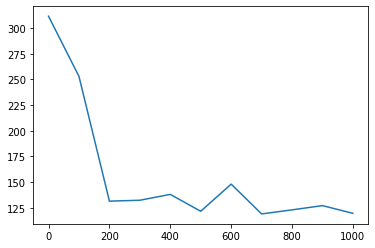

In [ ]:
# plot fid over steps
plt.plot(np.arange(0, n_steps, save_steps), fids)

In [ ]:
# load model with smallest (best) FID
g_model.load_weights('figan/weights' + str(np.arange(0, n_steps, save_steps)[np.argmin(fids)]) + '.h5')

<br>

## Synthetic Image Analysis

#### Plot real and synthetic images

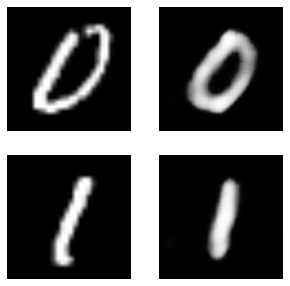

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (5, 5))
for digit in range(2):
  digit_index = np.random.choice(np.where(y_test[:,digit] == 1)[0])
  [X_realA, X_realB], y_real = generate_real_samples(x_test[digit_index:(digit_index + 1)], 
                                                    valid_x_tilde[digit_index:(digit_index + 1)], 
                                                    U_tilde)
  axs[digit, 0].imshow(X_realB[0,:,:,0], cmap = 'gray')
  axs[digit, 0].axis('off')
  axs[digit, 1].imshow(g_model.predict(X_realA, verbose = 0)[0,:,:,0], cmap = 'gray')
  axs[digit, 1].axis('off')

#### Generate synthetic images corresponding to the embedded features of the validation set

In [ ]:
# randomly sample an image from the validation set
[X_realA, X_realB], y_real = generate_real_samples(x_test, valid_x_tilde, U_tilde)

syn_images = list()
for samp_ind in range(100):
    if samp_ind % 10 == 0: print(samp_ind)
    for ii in range(valid_x_tilde.shape[1]):
        X_realA[:,:,:,ii+1] = valid_x_tilde[samp_ind,ii]
    
    syn_images.append(g_model.predict(X_realA, verbose = 0)[0,:,:,0])
syn_images = np.array(syn_images)

0
10
20
30
40
50
60
70
80
90


#### Smooth synthetic images for sequence

In [ ]:
from scipy.stats import norm

traj_maps = list()
for feat in range(U_tilde):
  vals = np.linspace(np.min(valid_x_tilde[:,feat]), np.max(valid_x_tilde[:,feat]), 21)
  traj_map = list()
  for val in vals:
      norm_pdf = norm.pdf(valid_x_tilde[0:len(syn_images),feat], loc = val, scale = 0.1)
      weights  = norm_pdf / np.sum(norm_pdf)
      traj_map.append(np.sum(np.transpose(syn_images, (1,2,0)) * weights, axis = -1))
  traj_maps.append(traj_map)

#### Plot synthetic image sequences

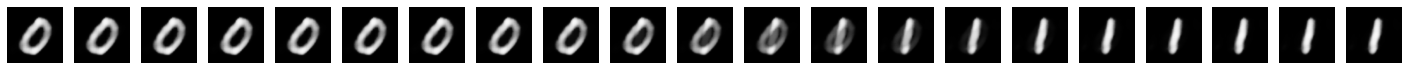

In [ ]:
for feat in range(U_tilde):
  traj_map = traj_maps[feat]
  fig, axs = plt.subplots(1, 21, figsize = (25, 5))
  for i in range(21):
    axs[i].imshow(traj_map[i], vmin = -1, vmax = 1, cmap = 'gray')
    axs[i].axis('off')

#### Plot eigen and deviation images

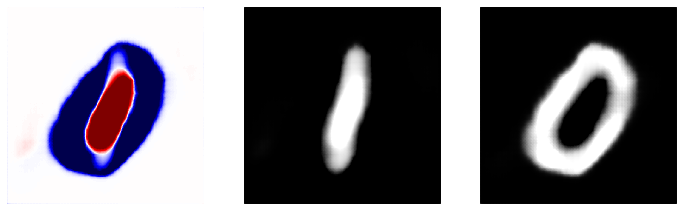

In [ ]:
from sklearn.decomposition import PCA

for feat in range(U_tilde):

  traj_map = traj_maps[feat]

  # calculate mean synthetic image
  traj_mean = np.mean(traj_map, axis = 0)

  pca = PCA(n_components = 1)
  pca_fit = pca.fit(np.resize(traj_map - traj_mean, (21,256*256)))

  eig_fun = np.resize(pca_fit.components_[0], (256,256))
  eig_val = np.sqrt(pca_fit.explained_variance_[0])

  # plot eigen and deviation images
  f,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize = (12,12))
  ax1.imshow(eig_fun*eig_val, vmin = -0.3, vmax = 0.3, cmap = 'seismic'); ax1.axis('off')
  ax2.imshow(traj_mean + 2*eig_val*eig_fun, cmap = "gray",
            vmin =-1, vmax = 1); ax2.axis('off')
  ax3.imshow(traj_mean - 2*eig_val*eig_fun, cmap = "gray",
            vmin =-1, vmax = 1); ax3.axis('off')